# 2.5. JAGGS

In [50]:
import pymc3 as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Metropolis Hastings using PyMC3

Consider the following model:

$$y_i | \mu \sim N(\mu, 1), ~~~~ i = 1, ..., n$$
$$\mu \sim t(0, 1, 1)$$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 24 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


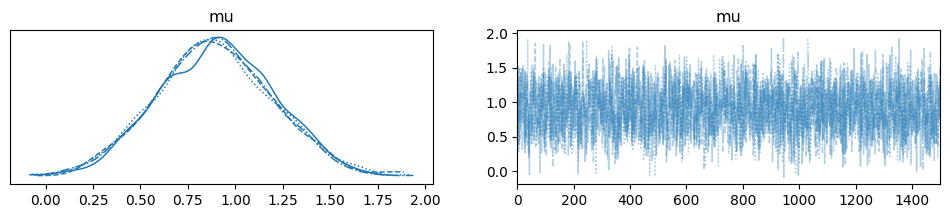

In [8]:
# Specify the data
y = np.array([1.2, 1.4, -0.5, 0.3, 0.9, 2.3, 1.0, 0.1, 1.3, 1.9])
n = len(y)

# Specify the model
with pm.Model() as model:
    mu = pm.StudentT('mu', nu=1, mu=0, sigma=1)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=1, observed=y)

# Run the MCMC sampler
with model:
    trace = pm.sample(1500, return_inferencedata=False)

# Post processing
az.plot_trace(trace)
plt.show()

In [15]:
az.summary( trace, round_to=4)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.8939,0.3117,0.321,1.4804,0.0062,0.0044,2548.4684,4075.6137,1.0005


## Gibbs Sampling: Conditionally Conjugate Prior Example with Normal Likelihood


Let's look at our model. Here's the full conditional update for the mean $\mu$:
$$N\left( \mu | \frac{n \bar{y}/\sigma^2 + \mu_0 / \sigma_0^2}{n/\sigma^2 + 1/\sigma_0^2}, \frac{1}{n/\sigma^2 + 1/\sigma_0^2}  \right)$$


And here's the full conditional update for the variance $\sigma^2$:

$$IG \left( \sigma^2 | \nu_0 + \frac{n}{2}, \beta_0 + \frac{ \sum_{i=1}^n ( y_i - \mu )^2 }{2}  \right)$$

We will need to write functions to simulate from these conditional updates


In [51]:
def update_mu(n, ybar, sig2, mu_0, sig2_0):
    sig2_1 = 1.0 / (n/sig2 + 1.0/sig2_0)
    mu_1 = sig2_1 * (n*ybar/sig2 + mu_0/sig2_0)
    return stats.norm.rvs(loc=mu_1, scale=np.sqrt(sig2_1), size=1)[0]

def update_sig2(n, y, mu, nu_0, beta_0):
    nu_1 = nu_0 + n/2.0
    sumsq = np.sum((y - mu)**2)
    beta_1 = beta_0 + sumsq/2.0
    return stats.invgamma.rvs(nu_1, scale=beta_1, size=1)[0]

def gibbs(y, n_iter, init, prior):
    ybar = np.mean(y)
    n = len(y)
    
    mu_out = np.empty(n_iter)
    sig2_out = np.empty(n_iter)
    
    mu_curr = init['mu']
    
    ## Gibbs sampler
    for i in range(n_iter):
        sig2_curr = update_sig2(n, y, mu_curr, prior['nu_0'], prior['beta_0'])
        sig2_out[i] = sig2_curr
        
        mu_curr = update_mu(n, ybar, sig2_curr, prior['mu_0'], prior['sig2_0'])
        mu_out[i] = mu_curr
    
    return pd.DataFrame(np.column_stack([mu_out, sig2_out]), columns=["mu", "sig2"])

def plot_posterior( posterior, ybar ):
    mu_posterior = posterior
    kde = stats.gaussian_kde(mu_posterior)
    x_values = np.linspace(min(mu_posterior) - 1, max(mu_posterior) + 1, 1000)
    density_values = kde(x_values)


    # change the size of the plot
    plt.figure(figsize=(6, 5))
    plt.plot(x_values, density_values)
    
    # get the x-axis
    x = np.linspace(-1.0, 2.5, 100)
    
    # make a dashed line
    plt.plot(x, stats.t.pdf(x, df=1, loc=0, scale=1), color='red', linewidth=2, linestyle='dashed');
    plt.scatter( ybar, 0, color='red', marker='o', zorder=2)
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.title('Kernel Density Estimate')
    plt.show()
    
def plot_hist(y, ybar):
    plt.figure(figsize=(6, 5))
    # plot the histogram of the data with no colors on the shape       
    plt.hist(y, bins=5, density=True, color='blue', alpha=0.5, edgecolor='black');
    plt.xlim(-1.0, 2.5)
    # add the data points
    plt.scatter( y, np.zeros(n), color='blue', marker='o', zorder=2)
    # add the sample mean
    plt.scatter( ybar, 0, color='red', marker='o', zorder=2)
    # add to the plot a prior consisting of a t-distribution with 3 degrees of freedom

    # get the x-axis
    x = np.linspace(-1.0, 2.5, 100)
    # make a dashed line
    plt.plot(x, stats.t.pdf(x, df=1, loc=0, scale=1), color='red', linewidth=2, linestyle='dashed');
    # add a legend saying that the red line is the prior
    plt.legend(["Sample data points", 'Sample mean', "Prior: t-student distribution"], loc='upper left')


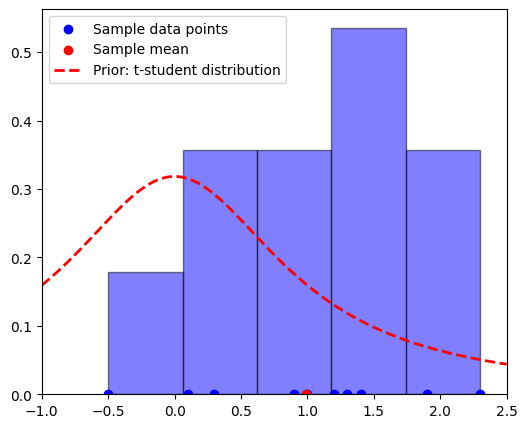

In [48]:
# setting up the program

y = np.array([1.2, 1.4, -0.5, 0.3, 0.9, 2.3, 1.0, 0.1, 1.3, 1.9])
ybar = np.mean(y)
n = len(y)

prior = { "mu_0" : 0.0, 
          "sig2_0" : 1.0, 
          "n_0" : 2.0,
          "s2_0" : 1.0,
          }
prior["nu_0"] = prior["n_0"] / 2.0
prior["beta_0"] = prior["n_0"] * (prior["s2_0"] / 2.0)

plot_hist(y, ybar)


In [70]:
# set seed
np.random.seed(53)

init = { "mu" : 0.0 }

n_iter = 1000

posterior = gibbs(y, n_iter, init, prior)
posterior_dict = {}
posterior_dict["mu"] = posterior["mu"].values
posterior_dict["sig2"] = posterior["sig2"].values
posterior


,mu,sig2
0,0.057140,2.533886
1,1.623251,1.288321
2,1.303944,1.194861
3,0.964858,0.639731
4,0.692301,0.720335
...,...,...
995,0.377140,0.380810
996,0.727683,1.009150
997,0.668815,0.548091
998,0.892005,0.616804


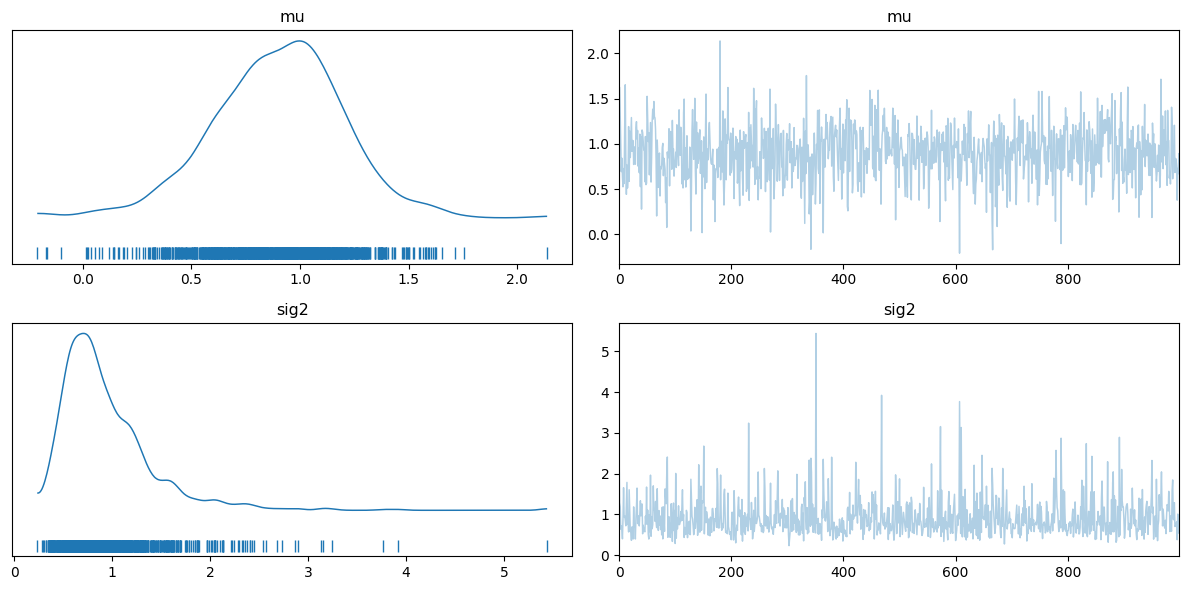

In [71]:
az.plot_trace(posterior_dict, figsize=(12, 6), rug=True)
plt.tight_layout()

In [72]:
az.summary( posterior_dict, round_to=4)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.8948,0.2989,0.3056,1.4043,0.0100,0.0071,874.5358,910.5049,NaN
sig2,0.9367,0.4798,0.2771,1.7021,0.0162,0.0115,866.3047,979.2293,NaN
